# Balzax environments

***To be run on Collab***

## Imports and modules

### Install Flax

In [1]:
!pip install flax

     |████████████████████████████████| 184 kB 5.2 MB/s 
     |████████████████████████████████| 140 kB 38.5 MB/s 
     |████████████████████████████████| 72 kB 458 kB/s 


### Install Balzax

In [2]:
!pip install git+https://github.com/charlypg/Balzax

  Cloning https://github.com/charlypg/Balzax to /tmp/pip-req-build-0u2c2ayq
  Running command git clone -q https://github.com/charlypg/Balzax /tmp/pip-req-build-0u2c2ayq
  Created wheel for balzax: filename=balzax-0.0.1-py3-none-any.whl size=7434 sha256=c1680d141e194f509d3067a19e2ec8fb5cbbc7412b833c2767881f05d8c1563a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_beyob_a/wheels/a3/2e/00/b25fcd14ca8aff910ad1c712f110f3b777be32dcfe232fa618
Successfully built balzax


### Imports

In [3]:
import jax
import jax.numpy as jnp
import flax
from functools import partial
import matplotlib.pyplot as plt
from time import time 

from balzax import BallsEnv, BallsEnvGoal

## Devices

In [4]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


## Testing vectorized BallEnv

In [5]:
OBS_TYPE = 'image' # @param ['position', 'image']
SEED = 0
NUM_ENV = 3

NB_ITER = 50

ACTION_0 = jnp.zeros((NUM_ENV,))
ACTION_1 = jnp.ones((NUM_ENV,))/2.

key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, num=NUM_ENV)

#print(keys)

env = BallsEnv(obs_type=OBS_TYPE)

vmap_env_reset = jax.jit(jax.vmap(env.reset))  # jax.vmap(env.reset)
vmap_env_step = jax.jit(jax.vmap(env.step))  # jax.vmap(env.step)

obs_list = []

print()
print("Observation type : {}".format(OBS_TYPE))
print("Seed : {}".format(SEED))
print("Number of envs : {}".format(NUM_ENV))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time du reset (jit+exec) : {}".format(time()-t0))
print()

#print(env_states)

observations = env_states.state.obs
print("observations : {}".format(observations.shape))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time du reset (second time exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.state.obs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_0)
print("First step (jit+exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.state.obs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_1)
print("Second step (exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.state.obs)

t0 = time()
for _ in range(NB_ITER):
    env_states = vmap_env_step(env_states, ACTION_1)
    obs_list.append(env_states.state.obs)
print("{0} iterations in {1}s".format(NB_ITER, time()-t0))
print()

pulse = 2*jnp.pi / NB_ITER * jnp.ones((NUM_ENV,))
t0 = time()
for i in range(NB_ITER):
    env_states = vmap_env_step(env_states, jnp.sin(pulse*i))
    obs_list.append(env_states.state.obs)
print("{0} iterations in {1}s".format(NB_ITER, time()-t0))
print()


Observation type : image
Seed : 0
Number of envs : 3

Time du reset (jit+exec) : 16.679338693618774

observations : (3, 224, 224, 1)

Time du reset (second time exec) : 0.003409862518310547

First step (jit+exec) : 1.428309679031372

Second step (exec) : 1.1957595348358154

50 iterations in 0.017809152603149414s

50 iterations in 0.2452249526977539s



## Show first environment of first iteration

(224, 224)


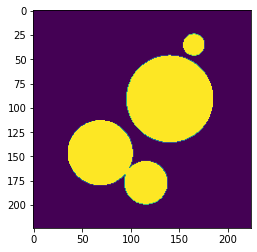

In [6]:
print(obs_list[0][0].squeeze().shape)
plt.imshow(obs_list[0][0].squeeze())

## Generate animation for the rollout

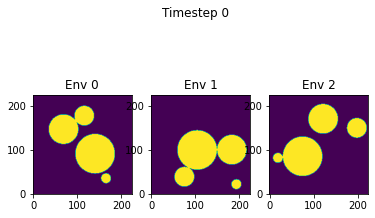

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

def animate(i):
    fig.suptitle('Timestep {}'.format(i))
    ax1.set_title('Env 0')
    ax1.imshow(obs_list[i][0].squeeze(), origin='lower')
    ax2.set_title('Env 1')
    ax2.imshow(obs_list[i][1].squeeze(), origin='lower')
    ax3.set_title('Env 2')
    ax3.imshow(obs_list[i][2].squeeze(), origin='lower')

ani = animation.FuncAnimation(fig, animate, frames=2*NB_ITER)
FFwriter = animation.FFMpegWriter()
ani.save('animation_rollout.mp4', writer=FFwriter)